# Packages and Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, recall_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, cohen_kappa_score
from sklearn.compose import ColumnTransformer,make_column_selector
from plotnine import *

In [3]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1
...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0
269,57,0,0,140,241,1,123,0
270,45,1,3,110,264,1,132,0
271,68,1,0,144,193,1,141,0


# Note:
Regressor models were not created because the variable we are predicting is categorical. The target variable we are predicting is artifically numeric therefore KNeighborsRegressor and DecisionTreeRegressor were not created.

# Part One: Fitting Models

## KNN Models

For the kNN models, I tried multiple different levels of k. The three levels I tried were 10, 50, and 60. I also created different lists with different values of k within the lists for each model during the tuning steps. I kept all the predictor variables within my pipeline.

In [4]:
# Define X and y, split the data
X = ha.drop('output', axis = 1)

y = ha['output']


In [5]:
# KNN model 1: k value 20

# pipeline

ct1 = ColumnTransformer(
  [("dummify", OneHotEncoder(sparse_output = False),["cp",
                                                      "restecg"], # take it out and run it to see error
),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough")


knn_pipeline1 = Pipeline(
  [("preprocessing", ct1),
  ("kNN", KNeighborsClassifier(n_neighbors = 50))] # use classifier because it's a categorical variable we're predicting
).set_output(transform="pandas")


# fit the model on actual dataset
fitted_knn1 = knn_pipeline1.fit(X,y)


# Tuning

k = [10, 30, 50, 70, 90, 110, 120, 150]

k_values = {'kNN__n_neighbors':k}

gscv1 = GridSearchCV(knn_pipeline1, k_values, cv = 5, scoring = 'roc_auc')
fitted_g = gscv1.fit(X,y)
results1 = pd.DataFrame(fitted_g.cv_results_)
results1

kNN = pd.DataFrame(data = {"k": results1['param_kNN__n_neighbors'],"scores": results1['mean_test_score']})

kNN.sort_values(by = 'scores', ascending = False)

# roc_auc score
prob1 = fitted_knn1.predict_proba(X)
roc_auc_score(y, prob1[:, 1], multi_class='ovr')

0.8494768633372883

### Conclusion for KNN:
k value of 50 did the best. However the roc auc scores for many other values of k had a mean test score that was similar.

roc auc score for k value of 50: output
0.8494768633372883

## Logistic Regression Models

I tried three different Logistic regression Models. The first model contains an elastic net penalty and I tuned to find the best l1_ratio alpha that had the best roc_auc score.

The second logistic regression model had a penalty of l2.

The third and final model had a penalty of l1.

The model that performed the best was Model 1 with the elasticnet penalty.

In [20]:
# Logistic model 1: Elastic Net Penalty, l1_ratio of 0.8

# pipeline
ct4 = ColumnTransformer(
  [("dummify",
    OneHotEncoder(sparse_output = False,handle_unknown='ignore'),['sex','cp','restecg']), # take it out and run it to see error),
    ("standardize",
    StandardScaler(),['age', 'trtbps','chol','thalach'])
  ],
  remainder = "passthrough")


l_pipeline1 = Pipeline(
  [("preprocessing", ct4),
  ("logistic", LogisticRegression(penalty = 'elasticnet', solver='saga', l1_ratio = 1))] # l1_ratio uses alphas; saga supports elastic regularization
).set_output(transform="pandas")


# fit the model on actual dataset
fitted_l1 = l_pipeline1.fit(X,y)


# Tuning

alphas = [0, 0.2, 0.4, 0.6, 0.8, 1]

alpha_values = {'logistic__l1_ratio':alphas}

gscv4 = GridSearchCV(l_pipeline1, alpha_values, cv = 5, scoring = 'roc_auc')
fitted_g4 = gscv4.fit(X,y)
results4 = pd.DataFrame(fitted_g4.cv_results_)
results4

logistic = pd.DataFrame(data = {"alpha": results4['param_logistic__l1_ratio'],"scores": results4['mean_test_score']})

logistic.sort_values(by = 'scores', ascending = False)

# Cross val - overall accuracy
scores = cross_val_score(l_pipeline1, X, y, cv = 5, scoring = 'accuracy')
scores.mean()

# Cross val - roc auc
scores = cross_val_score(l_pipeline1, X, y, cv = 5, scoring = 'roc_auc')
scores.mean()

# roc_auc score
prob = fitted_l1.predict_proba(X)
roc_auc_score(y, prob[:, 1], multi_class='ovr')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/line

0.8815122424765398

In [7]:
# Logistic model 2: L2 penalty

# pipeline
ct5 = ColumnTransformer(
  [("dummify",
    OneHotEncoder(sparse_output = False,handle_unknown='ignore'), # take it out and run it to see error
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough")


l_pipeline2 = Pipeline(
  [("preprocessing", ct5),
  ("logistic", LogisticRegression(penalty = 'l2'))] # use classifier because it's a categorical variable we're predicting
).set_output(transform="pandas")

fitted_l2 = l_pipeline2.fit(X,y)

# Cross val - overall accuracy
scores = cross_val_score(l_pipeline2, X, y, cv = 5, scoring = 'accuracy')
scores.mean()

# Cross val - roc_auc
scores = cross_val_score(l_pipeline2, X, y, cv = 5, scoring = 'roc_auc')
scores.mean()

# roc_auc score - positive class
# prob = fitted_l2.predict_proba(X)
# roc_auc_score(y, prob[:, 1], multi_class='ovr')

0.8533255526083113

In [8]:
# Logistical Model 3: l1 penalty

# pipeline
ct6 = ColumnTransformer(
  [("dummify",
    OneHotEncoder(sparse_output = False,handle_unknown='ignore'), # take it out and run it to see error
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough")

l_pipeline3 = Pipeline(
  [("preprocessing", ct6),
  ("logistic", LogisticRegression(penalty = 'l1', solver = 'saga'))] # use classifier because it's a categorical variable we're predicting
).set_output(transform="pandas")

fitted_l3 = l_pipeline3.fit(X,y)

# Cross val - overall accuracy
scores = cross_val_score(l_pipeline3, X, y, cv = 5, scoring = 'accuracy')
scores.mean()

# Cross val - roc_auc
scores = cross_val_score(l_pipeline3, X, y, cv = 5, scoring = 'roc_auc')
scores.mean()

# roc_auc score
# prob = fitted_l3.predict_proba(X)
# roc_auc_score(y, prob[:, 1], multi_class='ovr')

0.8559851458885941

### conclusion:

best model is logistic model 1

## Decision Tree models

In [9]:
# Decision Tree Model and Pipeline - alpha value of 5

ct7 = ColumnTransformer(
  [("dummify",
    OneHotEncoder(sparse_output = False,handle_unknown='ignore'), # take it out and run it to see error
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough")


dt_pipeline1 = Pipeline(
  [("preprocessing", ct7),
  ("decision_tree", DecisionTreeClassifier(ccp_alpha = 0.1))]
).set_output(transform="pandas")


# fit the model on actual dataset
fitted_dt1 = dt_pipeline1.fit(X,y)


# Tuning - alphas

alphas = [0.01, 0.1, 1, 2, 5, 10]
alphas2 = [0.001, 0.01, 0.15, 0.2, 0.3, 0.4, 0.5]

alpha_values = {'decision_tree__ccp_alpha':alphas2}

gscv7 = GridSearchCV(dt_pipeline1, alpha_values, cv = 5, scoring = 'roc_auc')
fitted_g7 = gscv7.fit(X,y)
results7 = pd.DataFrame(fitted_g7.cv_results_)
results7

dtree = pd.DataFrame(data = {"alphas": results7['param_decision_tree__ccp_alpha'],"scores": results7['mean_test_score']})

dtree.sort_values(by = 'scores', ascending = False)

# roc_auc score
prob1 = fitted_dt1.predict_proba(X)
roc_auc_score(y, prob1[:, 1], multi_class='ovr')


0.7536403839930967

# Part One: Conclusion
**kNN**: roc_auc 0.8494768633372883

**Logistic**: Model 1 with elastic net penalty and l1_ratio of 1 and roc_auc of 0.8676518174954158

**Decision Tree**: roc_auc 0.7536403839930967

# Part One: Best Model
**Cross-validated ROC AUC metric, Confusion Matrices, ROC AUC Curves,Coefficient Interpretations**

My Best model was the Logistic Regression with using elastic net penality and l1_ratio model.

Cross-Validated score: 0.8559851458885941

In [10]:
# Cross-Validation - kNN
scores = cross_val_score(l_pipeline1, X, y, cv = 5, scoring='roc_auc')
scores.mean()

0.8559851458885941

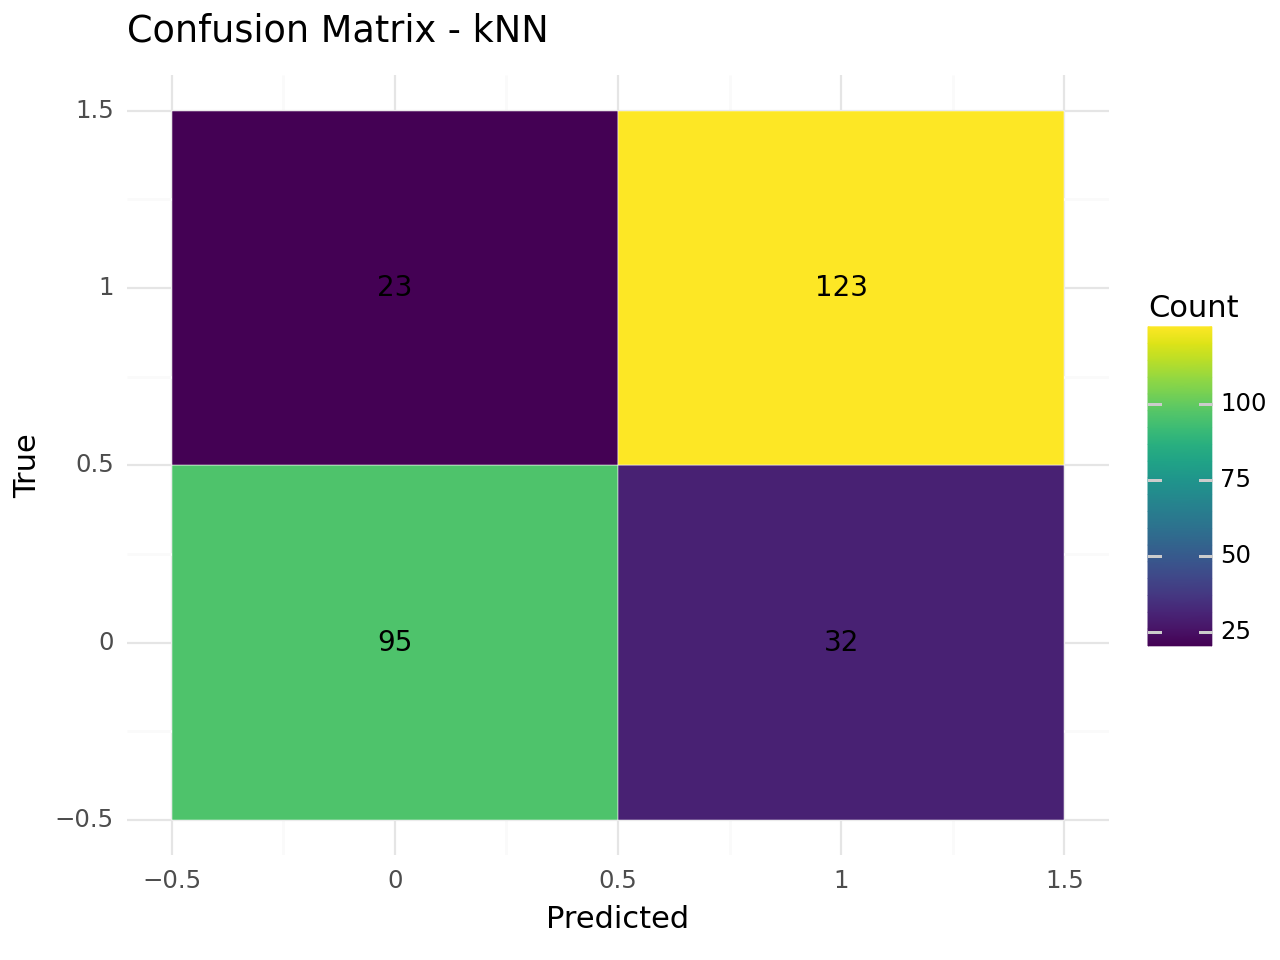

<Figure Size: (640 x 480)>

In [11]:
# Confusion matrix - kNN

pred_l1 = fitted_l1.predict(X)

lcm = confusion_matrix(y, pred_l1)
lcm_df = pd.DataFrame(lcm, index=fitted_l1.classes_, columns=fitted_l1.classes_)
lcm_df = lcm_df.unstack().reset_index()
lcm_df.columns = ['Predicted', 'True', 'Count']
lcm_df

# Plot confusion matrix using plotnine
(
    ggplot(lcm_df, aes(x='Predicted', y='True', fill='Count')) +
    geom_tile(color='white') +
    geom_text(aes(label='Count'), size=10, color='black') +
    labs(title='Confusion Matrix - kNN', x='Predicted', y='True') +
    theme_minimal()
)

In [25]:
# look at columns
dummy = ct4.fit_transform(X)
dummy

# get columns and check length
col = list(dummy.columns)
col

# Coefficients
lcoefs = l_pipeline1.named_steps['logistic'].coef_
lcoefs

lcoefs_flat = lcoefs.flatten()


# Dataframe
linear_coefficients = pd.DataFrame({'dependent_variable': col,'coefficients': lcoefs_flat})
linear_coefficients

,dependent_variable,coefficients
0,dummify__sex_0,1.421659
1,dummify__sex_1,-0.550328
2,dummify__cp_0,-1.921085
3,dummify__cp_1,0.053720
4,dummify__cp_2,0.000000
5,dummify__cp_3,0.000000
6,dummify__restecg_0,0.000000
7,dummify__restecg_1,0.286609
8,dummify__restecg_2,0.000000
9,standardize__age,-0.222193


Estimate Interpretation:
Based on this confusion matrix, the knn model I designed correctly identified 123/155 people as at risk of heart attack. It also correctly identified 95/118 people not at risk of heart attack.

Coefficient Interpretation:
The most influential coefficients seem to be sex, chest pain type, and maximum heart rate achieved during exercise.


I also made confusion matrix for the other models I created for comparison and as we can see, the knn model had the best results.


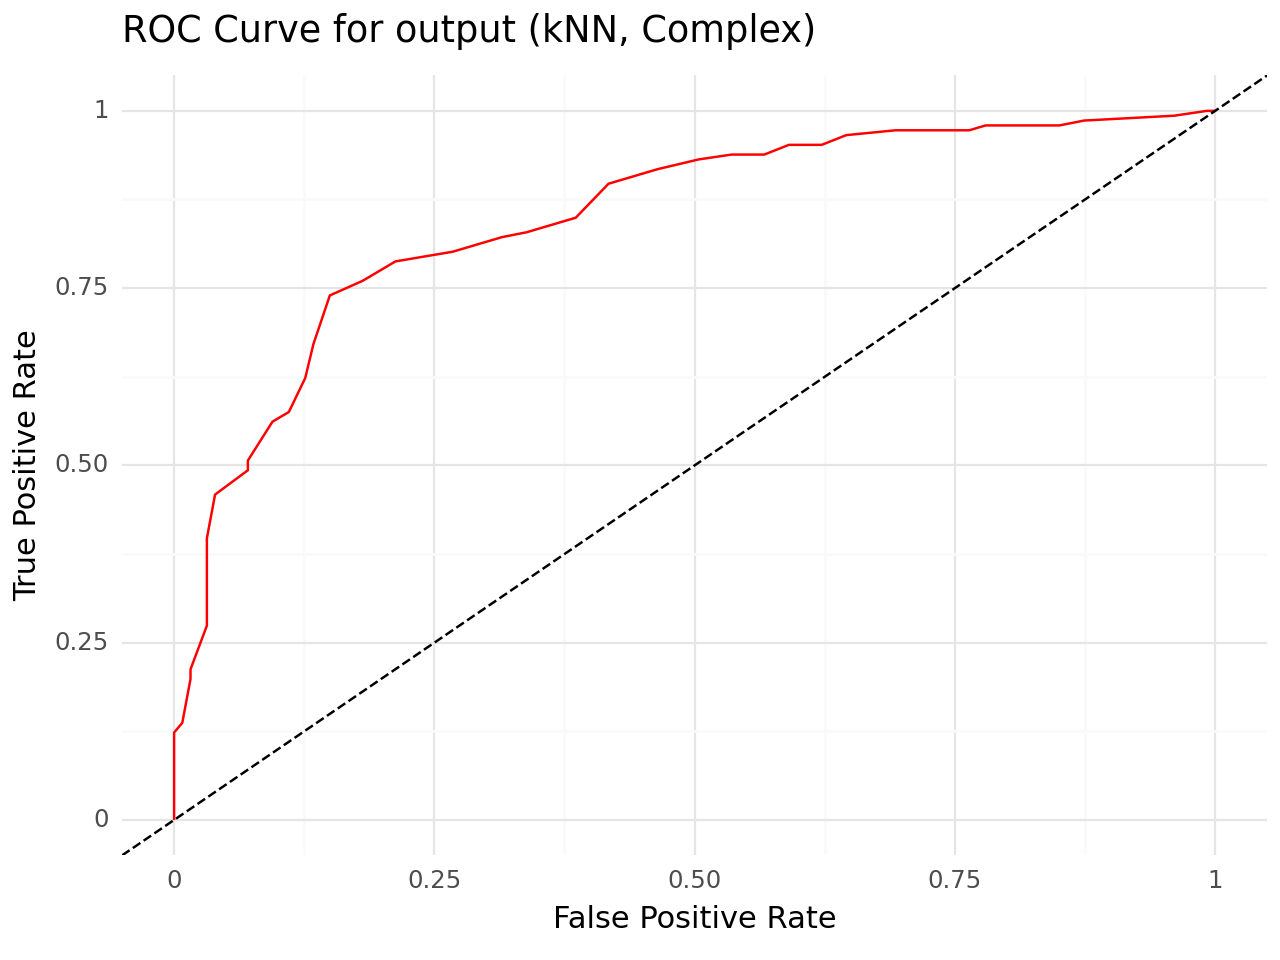

<Figure Size: (640 x 480)>

In [26]:
# ROC AUC Curve - kNN
from sklearn.preprocessing import label_binarize

# Predict probabilities
prob1 = fitted_knn1.predict_proba(X)


# Calculate ROC curve metrics for 'Gentoo' class
fpr_gentoo, tpr_gentoo, thresholds_gentoo = roc_curve(y, prob1[:, 1])

# Convert to DataFrame for plotting
roc_data_knn = pd.DataFrame({
    'False Positive Rate': fpr_gentoo,
    'True Positive Rate': tpr_gentoo
})

# Create ROC plot using plotnine
roc_plot_knn = (
    ggplot(roc_data_knn, aes(x='False Positive Rate', y='True Positive Rate'))
    + geom_line(color = "red")
    + geom_abline(linetype='dashed')
    + labs(title='ROC Curve for output (kNN, Complex)', x='False Positive Rate', y='True Positive Rate')
    + theme_minimal()
)

roc_plot_knn

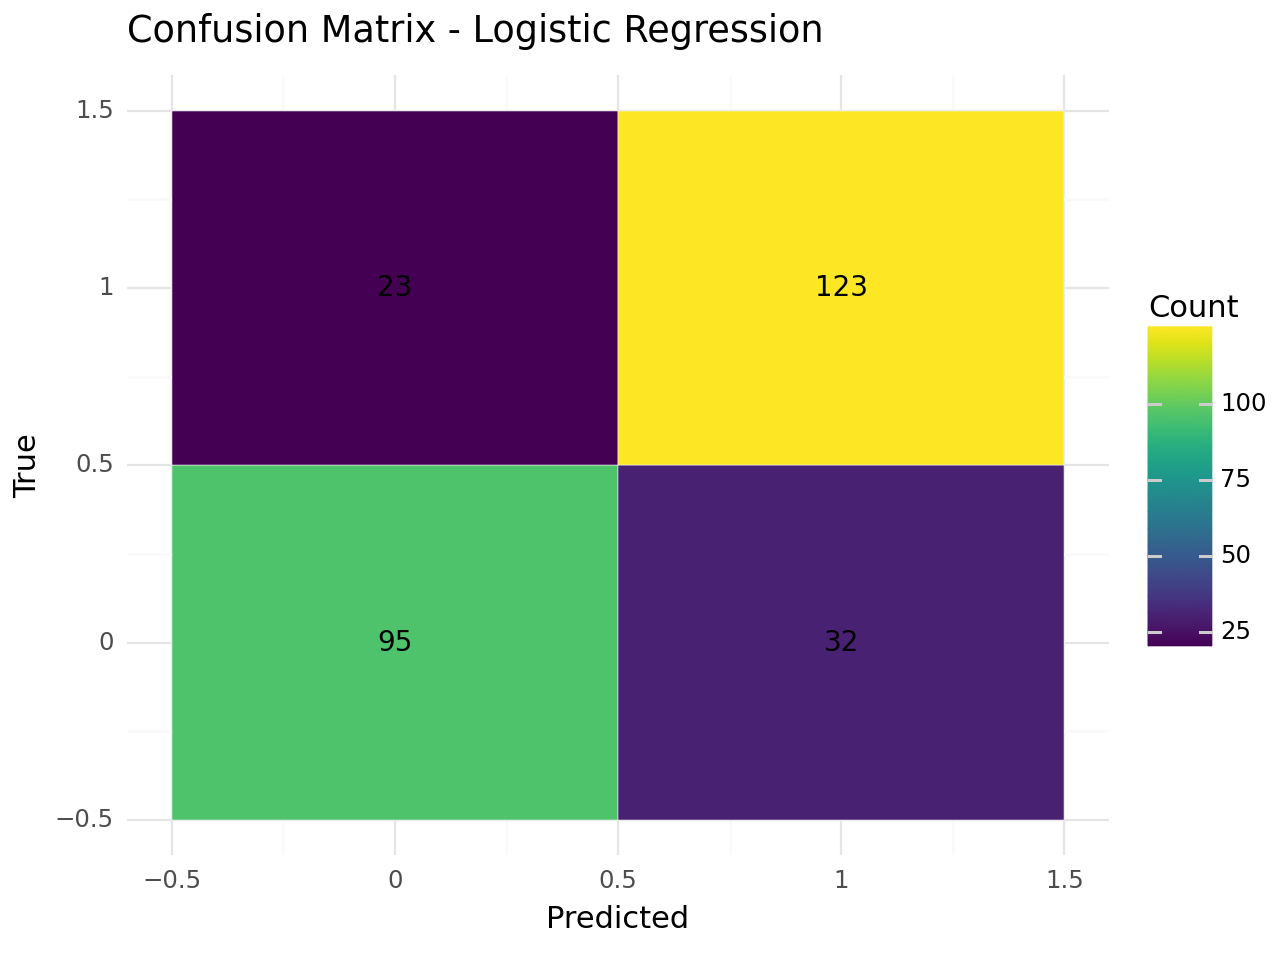

<Figure Size: (640 x 480)>

In [12]:
# Confustion Matrix - Logistic Regression

pred_l1 = fitted_l1.predict(X)

lcm = confusion_matrix(y, pred_l1)
lcm_df = pd.DataFrame(lcm, index=fitted_l1.classes_, columns=fitted_l1.classes_)
lcm_df = lcm_df.unstack().reset_index()
lcm_df.columns = ['Predicted', 'True', 'Count']
lcm_df

# Plot confusion matrix using plotnine
(
    ggplot(lcm_df, aes(x='Predicted', y='True', fill='Count')) +
    geom_tile(color='white') +
    geom_text(aes(label='Count'), size=10, color='black') +
    labs(title='Confusion Matrix - Logistic Regression', x='Predicted', y='True') +
    theme_minimal()
)


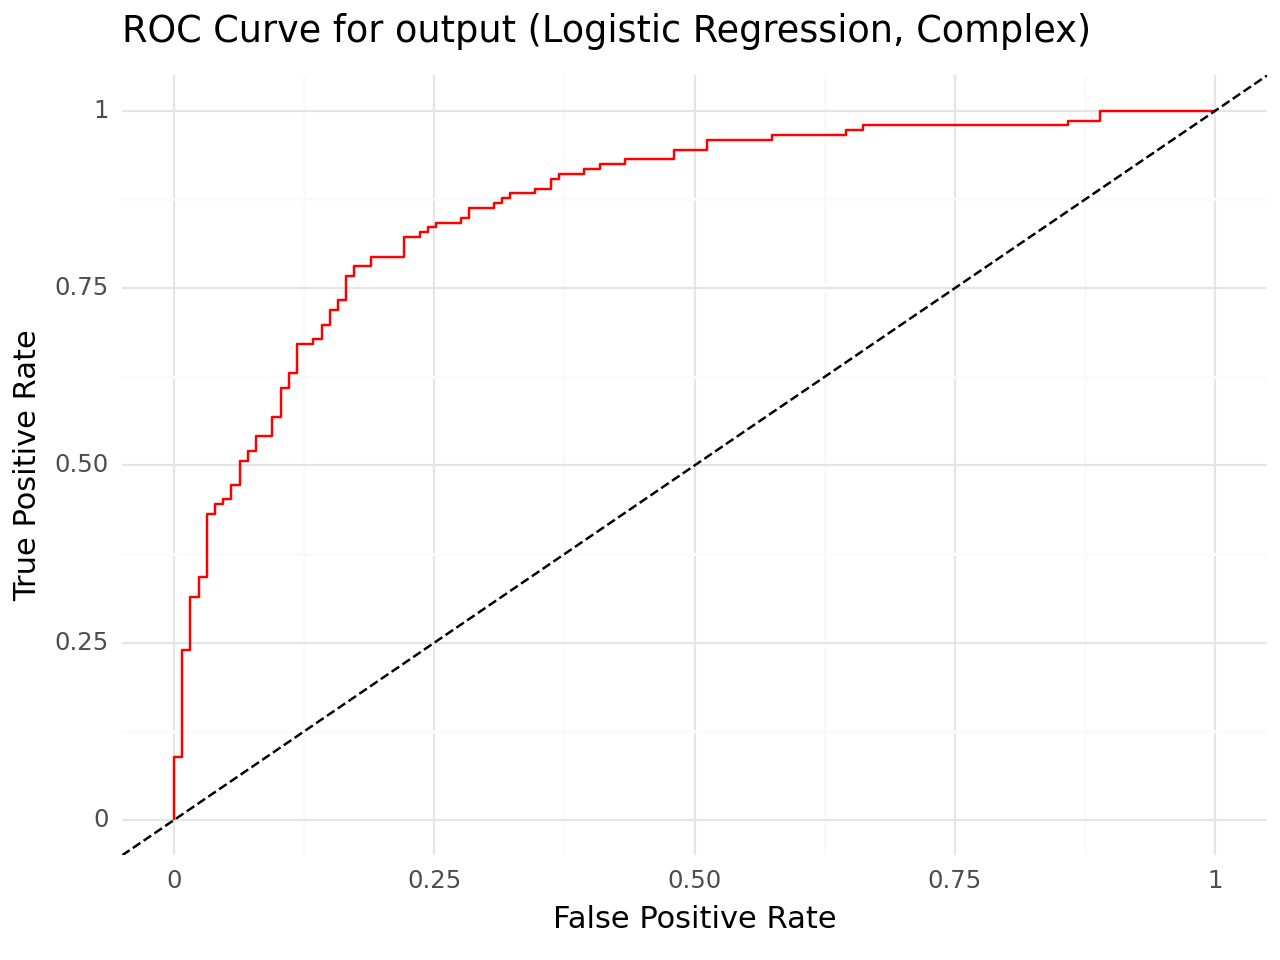

<Figure Size: (640 x 480)>

In [13]:
# ROC AUC Curve - Logistic Regression
from sklearn.preprocessing import label_binarize

# Predict probabilities
prob2 = fitted_l1.predict_proba(X)


# Calculate ROC curve metrics for 'Gentoo' class
fpr_gentoo, tpr_gentoo, thresholds_gentoo = roc_curve(y, prob2[:, 1])

# Convert to DataFrame for plotting
roc_data_l = pd.DataFrame({
    'False Positive Rate': fpr_gentoo,
    'True Positive Rate': tpr_gentoo
})

# Create ROC plot using plotnine
roc_plot_l = (
    ggplot(roc_data_l, aes(x='False Positive Rate', y='True Positive Rate'))
    + geom_line(color = "red")
    + geom_abline(linetype='dashed')
    + labs(title='ROC Curve for output (Logistic Regression, Complex)', x='False Positive Rate', y='True Positive Rate')
    + theme_minimal()
)

roc_plot_l

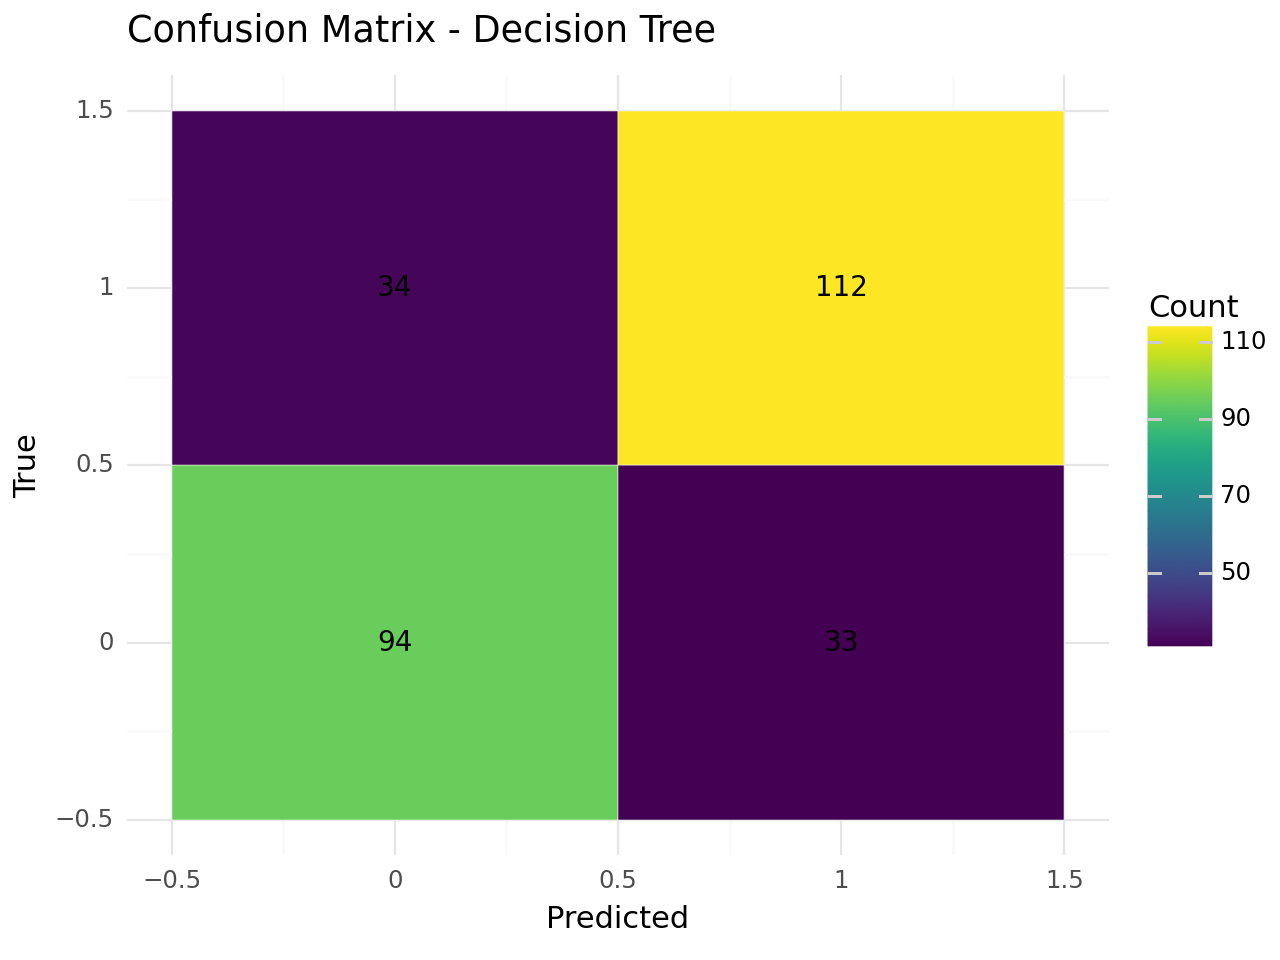

<Figure Size: (640 x 480)>

In [14]:
# Confustion Matrix - Decision Tree

pred_dt1 = fitted_dt1.predict(X)

dtcm = confusion_matrix(y, pred_dt1)
dtcm_df = pd.DataFrame(dtcm, index=fitted_dt1.classes_, columns=fitted_dt1.classes_)
dtcm_df = dtcm_df.unstack().reset_index()
dtcm_df.columns = ['Predicted', 'True', 'Count']
dtcm_df

# Plot confusion matrix using plotnine
(
    ggplot(dtcm_df, aes(x='Predicted', y='True', fill='Count')) +
    geom_tile(color='white') +
    geom_text(aes(label='Count'), size=10, color='black') +
    labs(title='Confusion Matrix - Decision Tree', x='Predicted', y='True') +
    theme_minimal()
)

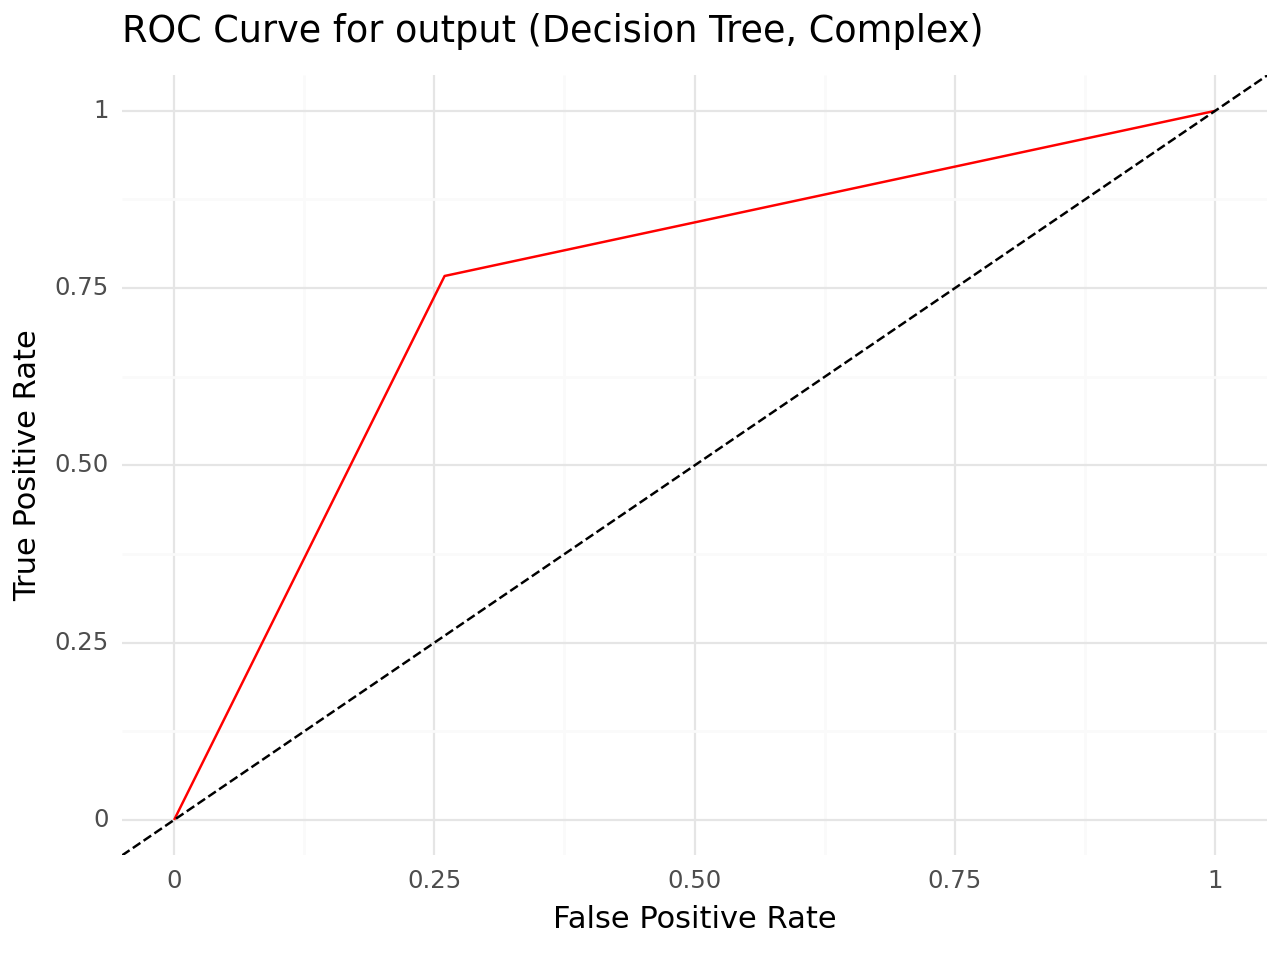

<Figure Size: (640 x 480)>

In [15]:
# ROC AUC Curve - Decision Tree
from sklearn.preprocessing import label_binarize

# Predict probabilities
prob3 = fitted_dt1.predict_proba(X)


# Calculate ROC curve metrics for 'Gentoo' class
fpr_gentoo, tpr_gentoo, thresholds_gentoo = roc_curve(y, prob3[:, 1])

# Convert to DataFrame for plotting
roc_data_dt = pd.DataFrame({
    'False Positive Rate': fpr_gentoo,
    'True Positive Rate': tpr_gentoo
})

# Create ROC plot using plotnine
roc_plot_dt = (
    ggplot(roc_data_dt, aes(x='False Positive Rate', y='True Positive Rate'))
    + geom_line(color = "red")
    + geom_abline(linetype='dashed')
    + labs(title='ROC Curve for output (Decision Tree, Complex)', x='False Positive Rate', y='True Positive Rate')
    + theme_minimal()
)

roc_plot_dt

# Part Two: Metrics

In [16]:
# KNN Model - k value of 50
# recall
recallk = cross_val_score(knn_pipeline1, X, y, cv = 5, scoring = 'recall')
recallk.mean()

# precision
preck = cross_val_score(knn_pipeline1, X, y, cv = 5, scoring = 'precision')
preck.mean()

# specificity
true_negativesk = 23  # Replace with your actual value
false_positivesk = 5  # Replace with your actual value
false_negativesk = 4  # Replace with your actual value
true_positivesk = 37  # Replace with your actual value

specificityk = true_negativesk / (true_negativesk + false_positivesk)
specificityk


# Logistic Regression Model 1
# recall
recalll = cross_val_score(l_pipeline1, X, y, cv = 5, scoring = 'recall')
recalll.mean()

#precision
precl = cross_val_score(l_pipeline1, X, y, cv = 5, scoring = 'precision')
precl.mean()

# specificity
true_negativesl = 21  # Replace with your actual value
false_positivesl = 7  # Replace with your actual value
false_negativesl = 7  # Replace with your actual value
true_positivesl = 34  # Replace with your actual value

specificityl = true_negativesl / (true_negativesl + false_positivesl)
specificityl


# Decision Tree - alpha 0.1
# recall
recalld = cross_val_score(dt_pipeline1, X, y, cv = 5, scoring = 'recall')
recalld.mean()

# precision
precl = cross_val_score(dt_pipeline1, X, y, cv = 5, scoring = 'precision')
precl.mean()

# specificity
true_negativesd = 21  # Replace with your actual value
false_positivesd = 7  # Replace with your actual value
false_negativesd = 5  # Replace with your actual value
true_positivesd = 36  # Replace with your actual value

specificityd = true_negativesd / (true_negativesd + false_positivesd)
specificityd


0.75

# Part Two: Final Computation

KNN:

*   recall: 0.8213793103448277
*   precision: 0.7747221469232854
*   specificity: 0.8214285714285714

Logistic:
* recall: 0.8151724137931036
* precision: 0.7918756530825497
* specificity: 0.75

Decision Tree:
*   recall: 1.0
*   precision: 0.7721332344580398
*   specificity: 0.75


# Part Three: Discussion

## Q1

I would choose recall because we are concerned with false negative. I would use ROC AUC curve to determine the discriminatory power of the model.
I would use Decision Tree. I would interpret the tree structure of the model. A decision tree model is easier to interpret and is best for decision making. It will guide the doctors and managers to decide which patients are most in need based on certain factors and parameters.


# Q2
I would use ROC AUC curve to deterimine the discriminatory power of the model and precision because we are more concerned with true postives and false positives. In this scenario, we are more concerned with finding the people who are truly high risk and that need the care the most therefore we are concerned with true positive rate.
I would use Logistic to find the coefficients that have the most influence in determining heart attack risk.



# Q3
I would focus on the ROC AUC scores, precision, and interpreting coefficients because we are concerned with true positives and the influences of heart attack risk.
I would use a Logistic Regression because one can look at the coefficients and interpret which coefficients have more influence and in which direction.

# Q4
The metrics to use for model selection would be overall accuracy because we want to see how accurate the new doctors are. Precision and Recall would also be appropriate measures to use to identify the true postive rate and true negative rate amongst the new doctors.
I would suggest Logistic Regression to interpret the coefficients that have the most influence in how a doctor is trained and whether their effectives is influenced by the training and/or other factors.

# Part Four: Validation

In [23]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
ha_validation

X2 = ha_validation.drop('output', axis = 1)

y2 = ha_validation['output']


pred_knnval = fitted_knn1.predict(X2)
pred_lval = fitted_l1.predict(X2)
pred_dtval = fitted_dt1.predict(X2)

In [24]:
# Confusion Matrix function

def confusion_matrix_pic(model_name,pipeline, X, y):
    '''
    Makes a confusion matrix visualization

    Parameter
    --------
    model_name : str
    fitted_model: fitted pipeline
    y : panda series of target variable
    y_pred: panda series from fitted_model.predict(X)

    Returns
    -------
    ggplot confusion matrix using plotnine

    '''
    # Fitted pipeline
    fitted_pipeline = pipeline.fit(X, y)

    # Predictions
    y_pred = fitted_pipeline.predict(X)

    # Dataframe
    kncm = confusion_matrix(y, y_pred)
    kncm_df = pd.DataFrame(kncm, index=fitted_pipeline.classes_, columns=fitted_pipeline.classes_)
    kncm_df = kncm_df.unstack().reset_index()
    kncm_df.columns = ['Predicted', 'True', 'Count']
    kncm_df

    # Plot confusion matrix using plotnine
    plot = (
    ggplot(kncm_df, aes(x='Predicted', y='True', fill='Count')) +
    geom_tile(color='white') +
    geom_text(aes(label='Count'), size=10, color='black') +
    labs(title=f'Confusion Matrix - {model_name}', x='Predicted', y='True') + # the f is for f-string to include model name
    theme_minimal()
    )
    return plot

In [25]:
# Report Function
def metric_report(pipeline, X, y):
    '''
    Makes a report of recall, precision, and ROC AUC score classification metrics

    Parameter
    --------
    fitted_pipeline : fitted sklearn pipeline
    X: pandas Dataframe that includes all predictor Variables
    y: panda series of target variable
    y_pred: panda series of target variable from fitted_model.predict(X)

    Returns
    -------
    Pandas Dataframe of all metric scores

    '''
    # Fitted Pipeline
    fitted_pipeline = pipeline.fit(X, y)


    # Get predictions
    y_pred = fitted_pipeline.predict(X)

    # Recall
    recall = recall_score(y, y_pred)

    # Precision
    precision = precision_score(y, y_pred)

    # ROC AUC
    # Assuming binary classification (multi_class='ovr' not needed for binary classification)
    roc_auc = roc_auc_score(y, fitted_pipeline.predict_proba(X)[:, 1])

    # Dataframe
    df = pd.DataFrame({"Recall": [recall], "Precision": [precision], "ROC AUC": [roc_auc]})

    return df

In [26]:
# kNN - ROC AUC, precision, recall
metric_report(knn_pipeline1, X, y)

,Recall,Precision,ROC AUC
0,0.787671,0.809859,0.849477


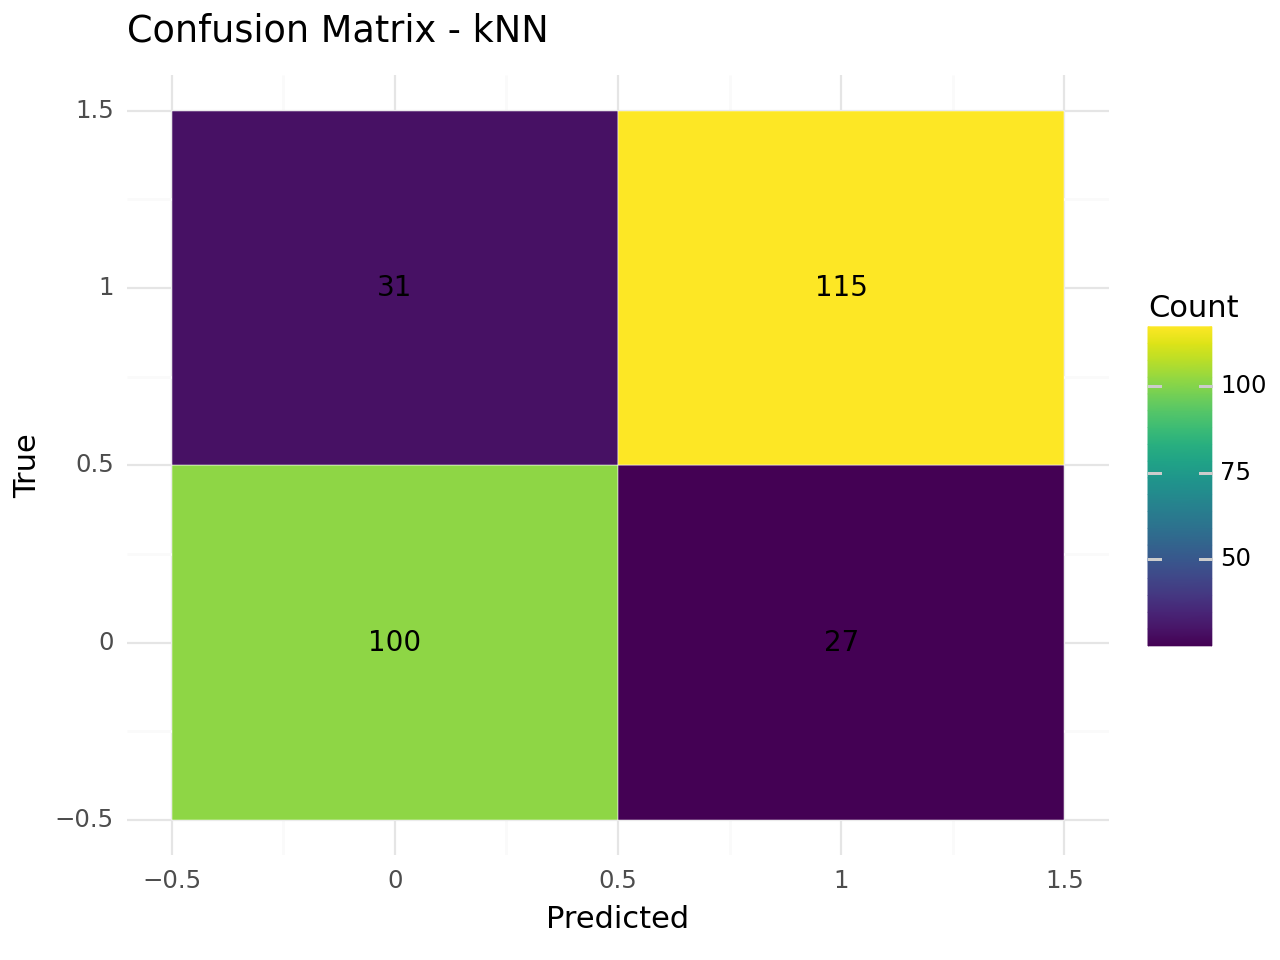

<Figure Size: (640 x 480)>

In [27]:
# kNN - Confusion Matrix
confusion_matrix_pic('kNN', knn_pipeline1, X, y)

In [28]:
# Logistic Regression - Metric Report
metric_report(l_pipeline1, X, y)

,Recall,Precision,ROC AUC
0,0.842466,0.793548,0.867652


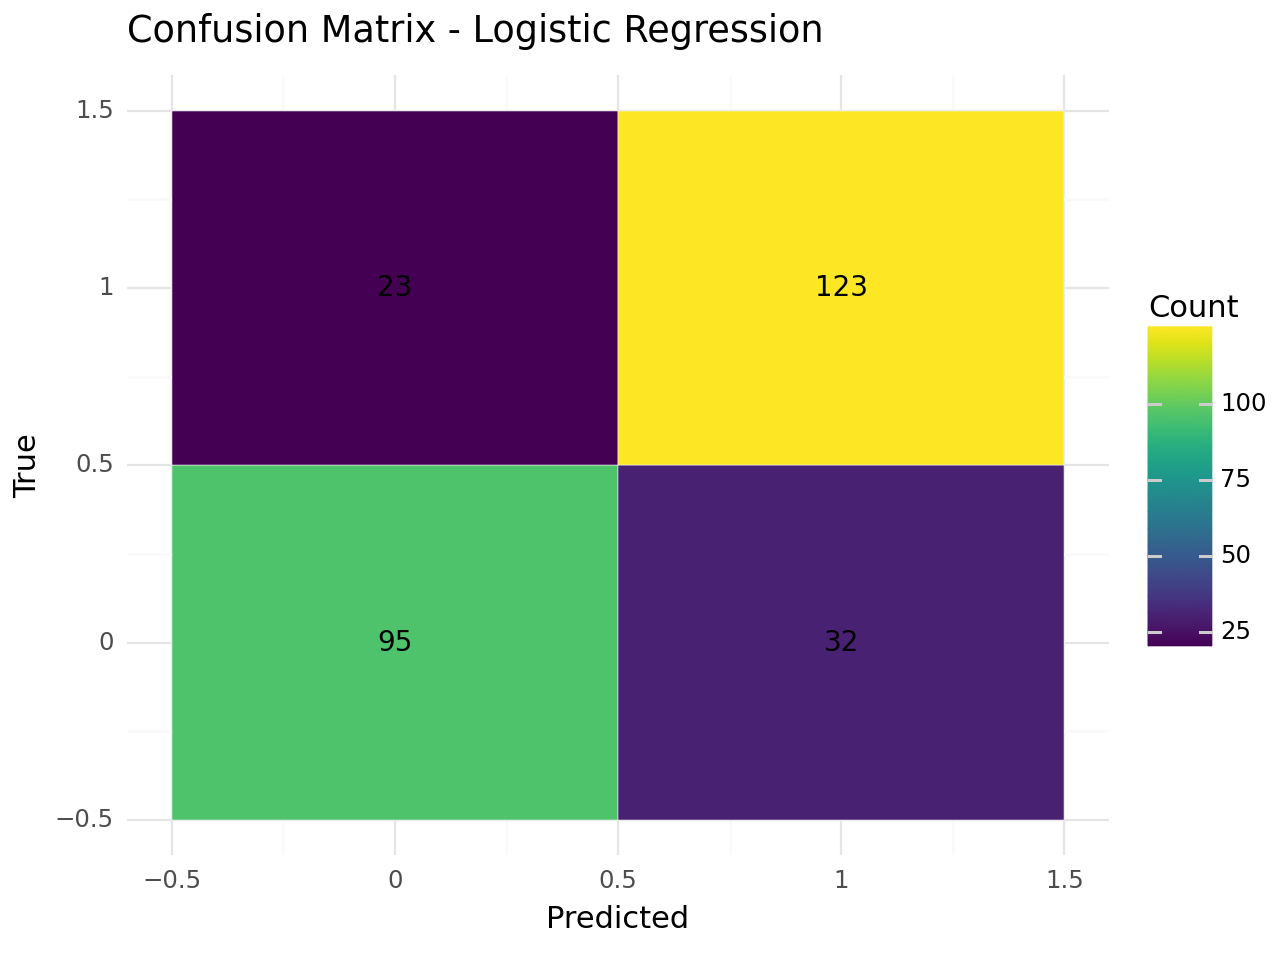

<Figure Size: (640 x 480)>

In [29]:
# Logistic Regression - Confusion Matrix
confusion_matrix_pic('Logistic Regression', l_pipeline1, X, y)

In [30]:
# Decision Tree - Metric Report
metric_report(dt_pipeline1, X, y)

,Recall,Precision,ROC AUC
0,0.767123,0.772414,0.75364


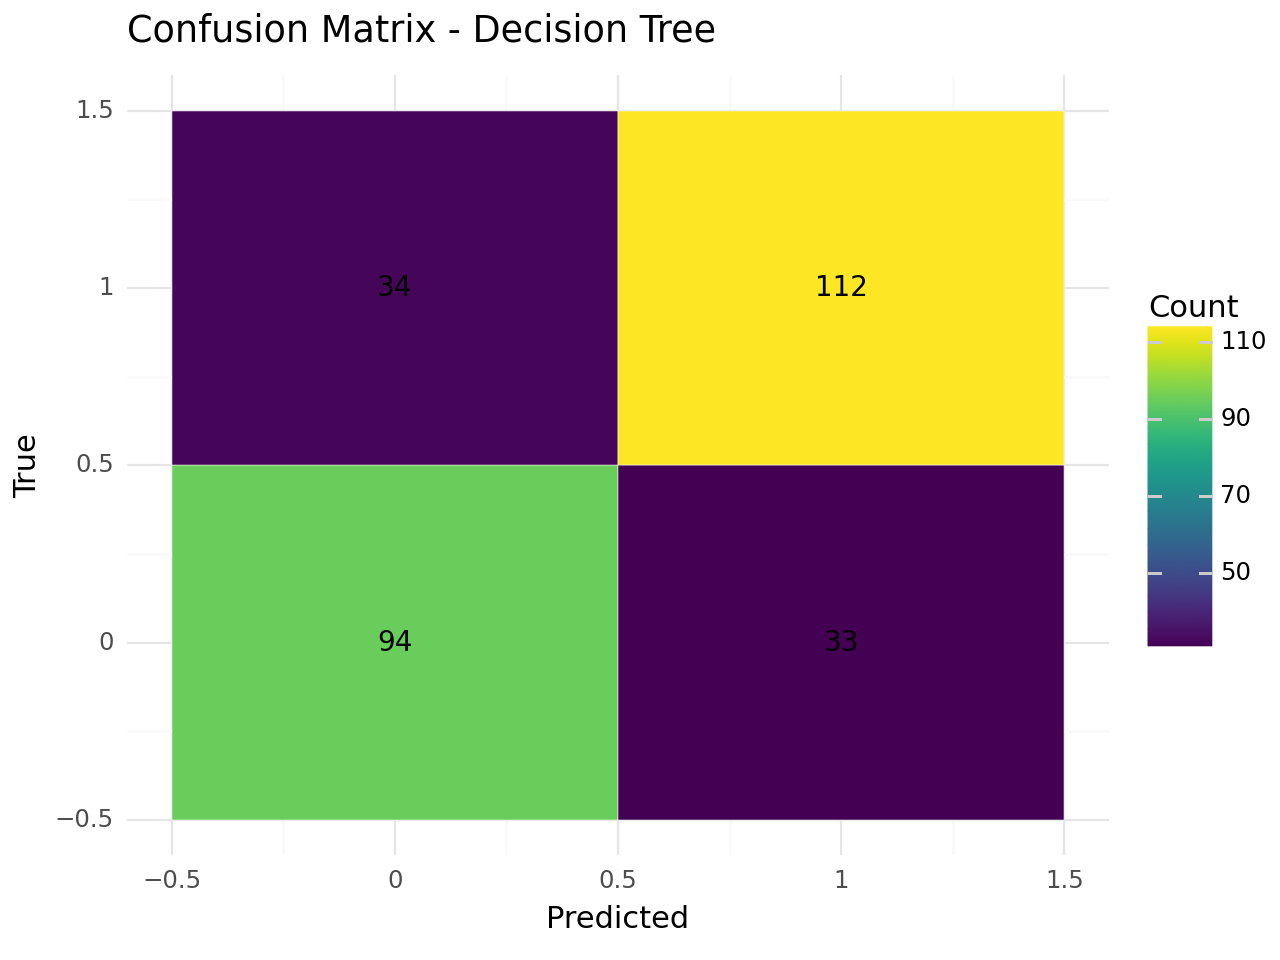

<Figure Size: (640 x 480)>

In [31]:
# Decision Tree - Confusion Matrix
confusion_matrix_pic('Decision Tree', dt_pipeline1, X, y)

# Part Four: Comparison Conclusion

Logistic still did the best.

All models scored a score higher than 0.7 on all the metrics.

Decision Tree did the worst again overall.

Measure of model success turned out to be approximately correct for the validation data. Compared to the estimates I calculated in Part One and Part Two, all of my models performed better.

# Part Five: Cohen's Kappa

Cohen's Kappa: metric used to measure performance of machine learning classification models based on assessing the perfect agreement and agreement by change between the two raters.

It assumes raters are independenct meaning their ratings are not influence by each other.

*  score <= 0, no agreement
*  0.41-0.6 moderate agreement
*  0.61-0.8 substantial agreement
*  0.81-1.00 almost perfect agreement

In [32]:
# Cohen Function
def cohen_report(pipeline, X, y):
    '''
    Makes a report of recall, precision, and ROC AUC score classification metrics

    Parameter
    --------
    pipeline : sklearn pipeline
    X: pandas Dataframe that includes all predictor Variables\
    y: panda series of target variable

    Returns
    -------
    cohen kappa score

    '''
    # Fitted Pipeline
    fitted_pipeline = pipeline.fit(X, y)

    # Get predictions
    y_pred = fitted_pipeline.predict(X)

    # cohen
    cohen = cohen_kappa_score(y, y_pred)


    return cohen

In [33]:
cohen_report(knn_pipeline1, X, y)

0.5738966630785791

In [34]:
cohen_report(l_pipeline1, X, y)

0.5932327364343186

In [35]:
cohen_report(dt_pipeline1, X, y)

0.5070209956068242

## C:
*  Reasons or Scenarios that would make us prefer to use this metric as our model success

This metric would be useful when we are concerned with dataset variation, reducing randomness, and accounting for correct and incorrect predictions.

The Cohen score for my kNN model and Logistic Regression model suggest a substantial agreement between my y actual values and my y predicted values. This means that my models' predictions align with the true outcomes.

*  Do you conclusions from above change if you judge your models using Cohen's Kappa?

My conclusions do not change necessarily change my judgement on my past models. If anything they reaffirm my decisions.

